In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re, nltk
from itertools import product
from sklearn.metrics import confusion_matrix, accuracy_score, average_precision_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB

In [ ]:
pandas.read_csv(filename, sep='\t', lineterminator='\r')

In [8]:
data = pd.read_csv("../hotaling_cocktails - Cocktails.csv")


In [9]:
data.head()

,Cocktail Name,Bartender,Bar/Company,Location,Ingredients,Garnish,Glassware,Preparation,Notes
0,Flor de Amaras,Kelly McCarthy,NaN,Boston,"1.5 oz Mezcal, 1 oz Hibiscus Simple Syrup*, .5...",Marigold Petals,NaN,*Hibiscus Simple Syrup:\n1:1 w/ a cup of dried...,NaN
1,The Happy Place,Elizabeth Montana,Forgery & Verso,San Francisco,"2 oz Junipero Gin, .75 oz House-made Cranberry...","Dehydrated Lemon Wheel, Sprig of Rosemary",NaN,*House-made Cranberry syrup: \n-- 2 cups Fresh...,Junipero Gin 20th Anniversary Signature Cocktail
2,Bon Voyage Pisco Punch,Jon Morales,NaN,San Francisco,"1500 ml BarSol Selecto Italia Pisco, 750 ml Le...",NaN,Punch Bowl,*Pineapple Gomme: \nMix equal parts (1.5 cups)...,NaN
3,Still Life of a Pineapple,Daniel Braganca,Backbar,Somerville,"1.5 oz BarSol Primero Quebranta Pisco, .75 oz ...",NaN,NaN,*Pineapple Syrup:\n<em>Equal parts pineapple b...,NaN
4,The Bittered Valley,Nik Virrey,NaN,Seattle,"1.25 oz Luxardo Maraschino Liqueur, 4 drops Ac...",NaN,NaN,"1st glass ingredients:\nLuxardo Maraschino, Ac...",NaN


In [10]:
data.describe()

,Cocktail Name,Bartender,Bar/Company,Location,Ingredients,Garnish,Glassware,Preparation,Notes
count,687,452,270,342,687,523,485,642,151
unique,684,250,168,41,686,318,66,630,102
top,Negroni,Francesco Lafranconi,Dirty Habit,San Francisco,"1 oz No.3 London Dry Gin, 1 oz Tempus Fugit Al...",Luxardo Cherry,Coupe,Shake until very cold; double strain into a ch...,Featured on Speed Rack 2015 SF Speed City Take...
freq,2,38,29,156,2,32,107,3,18


In [13]:
data.shape

(687, 9)

In [12]:
data.isnull().sum()

Cocktail Name      0
Bartender        235
Bar/Company      417
Location         345
Ingredients        0
Garnish          164
Glassware        202
Preparation       45
Notes            536
dtype: int64

In [14]:
data = data.drop(['Bartender','Bar/Company','Location','Garnish','Glassware','Notes'],  axis=1)

In [15]:
data.describe()

,Cocktail Name,Ingredients,Preparation
count,687,687,642
unique,684,686,630
top,Negroni,"1 oz No.3 London Dry Gin, 1 oz Tempus Fugit Al...",Shake until very cold; double strain into a ch...
freq,2,2,3


In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(data['v1'])
data['v1'] = le.transform(data.v1.values)

In [ ]:
data.describe()

In [18]:
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer 
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/amankedia/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/amankedia/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [34]:
def text_clean(corpus, keep_list):
    cleaned_corpus = pd.Series()
    for i, row in enumerate(corpus):
        print(i, row)
        qs = []
        for word in row.split():
            if word not in keep_list:
                p1 = re.sub(pattern='[^a-zA-Z0-9]',repl=' ',string=word)
                p1 = p1.lower()
                qs.append(p1)
            else : qs.append(word)
        cleaned_corpus = cleaned_corpus.append(pd.Series(' '.join(qs)))
    return cleaned_corpus

In [21]:
def preprocess(corpus, keep_list, cleaning = True, stemming = False, stem_type = None, lemmatization = True, remove_stopwords = True):

    if cleaning == True:
        corpus = text_clean(corpus, keep_list)
    
    if remove_stopwords == True:
        wh_words = ['who', 'what', 'when', 'why', 'how', 'which', 'where', 'whom']
        stop = set(stopwords.words('english'))
        for word in wh_words:
            stop.remove(word)
        corpus = [[x for x in x.split() if x not in stop] for x in corpus]
    else :
        corpus = [[x for x in x.split()] for x in corpus]
    
    if lemmatization == True:
        lem = WordNetLemmatizer()
        corpus = [[lem.lemmatize(x, pos = 'v') for x in x] for x in corpus]
    
    if stemming == True:
        if stem_type == 'snowball':
            stemmer = SnowballStemmer(language = 'english')
            corpus = [[stemmer.stem(x) for x in x] for x in corpus]
        else :
            stemmer = PorterStemmer()
            corpus = [[stemmer.stem(x) for x in x] for x in corpus]
    
    corpus = [' '.join(x) for x in corpus]
        

    return corpus

In [23]:
common_dot_words = ['U.S.', 'St.', 'Mr.', 'Mrs.', 'D.C.']
data['Cocktail Name'] = preprocess(data['Cocktail Name'], keep_list = common_dot_words, remove_stopwords = True)




In [24]:
data['Cocktail Name']

0              flor de amaras
1                 happy place
2      bon voyage pisco punch
3        still life pineapple
4               bitter valley
                ...          
682            negroni bianco
683          match grip julep
684                dry cruise
685                  red hook
686                union jack
Name: Cocktail Name, Length: 687, dtype: object

In [25]:
data['Ingredients'] = preprocess(data['Ingredients'], keep_list = common_dot_words, remove_stopwords = True)


In [26]:
data['Ingredients']

0      1 5 oz mezcal 1 oz hibiscus simple syrup 5 oz ...
1      2 oz junipero gin 75 oz house make cranberry s...
2      1500 ml barsol selecto italia pisco 750 ml lem...
3      1 5 oz barsol primero quebranta pisco 75 oz dr...
4      1 25 oz luxardo maraschino liqueur 4 drop acid...
                             ...                        
682    1 5 oz luxardo bitter bianco 75 oz tempus fugi...
683    1 5 oz h hine 5 oz jamaican rum 1 tsp cacao 1 ...
684    1 oz luxardo bitter bianco 1 oz lustau oloroso...
685    2 oz rye whiskey 5 oz punt e mes 5 oz luxardo ...
686    75 oz luxardo maraschino liqueur 75 oz green c...
Name: Ingredients, Length: 687, dtype: object

In [42]:
data = data.dropna()
# data = data.iloc([642:,])

data['Preparation'] = preprocess(data['Preparation'], keep_list = common_dot_words, remove_stopwords = True)




0 *Hibiscus Simple Syrup:
1:1 w/ a cup of dried hibiscus steeping for 30-40 min
1 *House-made Cranberry syrup: 
-- 2 cups Fresh Cranberries
-- 1 cup Sugar
-- 1 cup Water
-- 2 Bay Leaves
-- .25 cup Pink Peppercorns
-- Half Serrano Chile
-- 4 Sprigs Fresh Rosemary

Add all ingredients to a pot and heat thoroughly. Simmer on low until cranberries cook down for 25 minutes. Strain and let cool.
2 *Pineapple Gomme: 
Mix equal parts (1.5 cups) gum arabic with water over high heat until it all mixes and then let cool for a bit. Then you're gonna make a sugar syrup with 2 parts sugar, 1 part water (4 cups water, 2 cups white granulated sugar) in the same manner over high heat until it mixes, and then add the gum syrup to the mix until everything dissolves and what you're left with is a thick gummy syrup that resembles a whole lot of baby batter. Then cut up 1.5 cups of pineapple chunks, put in mason jar, and pour the gum syrup over it and let it sit in the refrigerator over night. A few hours w

253 In a mixing glass, add ice and shake with all of the ingredients. Strain over new ice (large sphere ice cube) and serve in old fashioned glass and grate fresh cinnamon over the ice.

*Apple Cider Reduction: Boil apple cider until it reduces in volume by half.

**Cinnamon-Chipotle Syrup: Bring 1 cup sugar, 1 cup water and 3 cinnamon sticks to boil, take off heat and let steep for 20mins, add chipotle powder and mix well.
254 In a mixing glass, add the first three ingredients over ice. Stir to chill. In a separate coupe glass, add .5 oz of Luxardo Fernet and swirl glass until it is fully coated with the Fernet. Strain chilled cocktail from mixing glass into the Fernet-rinsed coupe (discard excess fernet). Garnish by placing a Luxardo Cherry into the bottom of the glass.
255 In a mixing glass, combine Pink Pigeon Rum, Lychee Juice and the juice from 1/2 a lime. Add the pulp of one passion fruit (to prep passion fruit: cut in half, setting aside a small slice for garnish and scoop out 

497 Shake with ice to mix and emulsify. Strain into a chilled old fashioned glass filled with ice. Garnish with Luxardo Maraschino Cherries and fresh lemon zest.
498 Shake with ice, strain and pour into a chilled martini glass.
499 Shake with ice, strain into a coupe. No garnish.
500 Shake with ice, strain into flute, top with sparkling rose and a grapefruit twist.
501 Shake with ice. Strain into a chilled cocktail glass.
502 Shake with ice. Strain into chilled martini glass. Garnish with lemon peel.
503 Shake with ice. Strain into rocks glass and top with crushed ice. Float 1 oz. of Gosslings 151 rum on top.  Garnish with mint and Luxardo Maraschino Cherries.
504 Shake with intent. Double strain in coupe. Garnish with lemon wheel.
505 Shake without ice, add ice and shake again then fine strain into a chilled egg coupe. Garnish with a Sage leaf.
506 Shake without ice, to whip and emulsify ingredients until frothy. Add ice to shaker and shake vigorously. Strain into port glass or small 

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [43]:
data

,Cocktail Name,Ingredients,Preparation
0,flor de amaras,1 5 oz mezcal 1 oz hibiscus simple syrup 5 oz ...,hibiscus simple syrup 1 1 w cup dry hibiscus s...
1,happy place,2 oz junipero gin 75 oz house make cranberry s...,house make cranberry syrup 2 cup fresh cranber...
2,bon voyage pisco punch,1500 ml barsol selecto italia pisco 750 ml lem...,pineapple gomme mix equal part 1 5 cup gum ara...
3,still life pineapple,1 5 oz barsol primero quebranta pisco 75 oz dr...,pineapple syrup em equal part pineapple blend ...
4,bitter valley,1 25 oz luxardo maraschino liqueur 4 drop acid...,1st glass ingredients luxardo maraschino acid ...
...,...,...,...
637,negroni sorbetto,5 oz junipero gin 5 oz luxardo bitter 5 oz tem...,whisk ingredients birdie tin pour coupe glass ...
638,amaretto jello shoot why,2 cup boil water 6 package raspberry jello pac...,recipe jello shots
639,local edition punch,12 bottle h hine 4 bottle luxardo apricot liqu...,combine ingredients punch bowl mix well
640,classic lolita,2 oz nikka whisky taketsuru 5 oz okinawa sugar...,muddle okinawa sugar bitter add whisky stir to...


Text(0.5, 1.0, 'Top Twenty Counts of Most-Common Words Among Text')

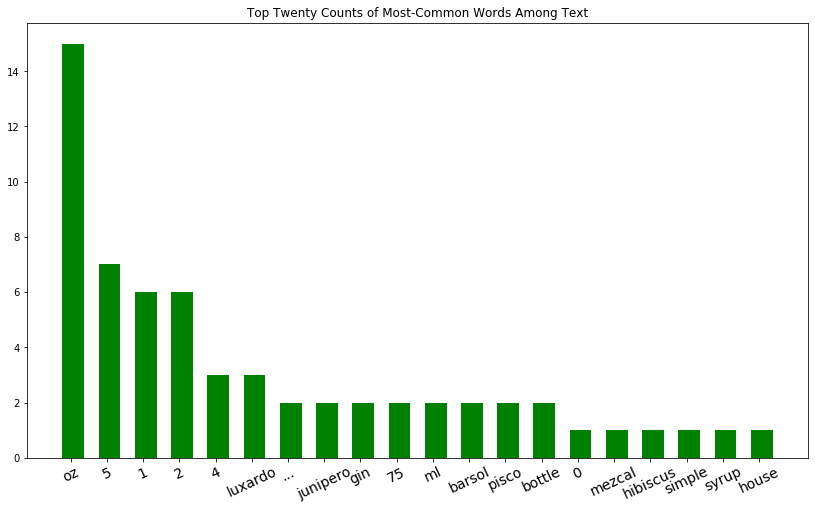

In [73]:
from collections import Counter
tops = Counter(str(data['Ingredients']).split()).most_common()[:20]
labs, vals = zip(*tops)
idx = np.arange(len(labs))
wid=0.6
fig, ax=plt.subplots(1,1,figsize=(14,8))
ax=plt.bar(idx, vals, wid, color='g')
ax=plt.xticks(idx - wid/8, labs, rotation=25, size=14)
plt.title('Top Twenty Counts of Most-Common Words Among Text')

In [76]:
results = set()
data['Ingredients'].str.lower().str.split().apply(results.update)
print(len(results))


1056


In [52]:
# X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0, stratify = Y)
X_train, X_test = train_test_split(data, test_size=0.2, random_state=0)

In [53]:
X_train.shape

(513, 3)

In [58]:
X_train

,Cocktail Name,Ingredients,Preparation
12,west coast punch,1 5 oz junipero gin 75 oz pineapple juice 5 oz...,add ingredients mix glass fresh ice shake vigo...
386,king mull cider,2 oz king ginger liqueur 5 oz hard apple cider...,serve handle glass hot ice garnish lemon cinna...
573,manhattan,2 oz rye bourbon whiskey 1 oz tempus fugit spi...,stir strain garnish luxardo maraschino cherry
499,almond brother,2 oz reposado tequila 25 oz luxardo amaretto d...,shake ice strain coupe garnish
78,king ginger summer cup,1 oz king ginger liqueur 1 5 oz cranberry juic...,build glass ice add lemon wheel strawberries f...
...,...,...,...
9,king snap chocolate,1 oz king ginger liqueur 1 5 oz homemade milk ...,add ingredients except whip cream ginger snap ...
359,duke classic dry martini,3 oz 3 london dry gin 1 tsp extra dry vermouth...,pour extra dry vermouth freeze martini glass e...
192,regal air,3 oz domingo perez marin la guita manzanilla s...,combine ingredients roll gently ice strain mar...
629,brisa del sur,1 5 oz barsol selecto italia pisco 5 oz rocoto...,top grapefruit soda shake strain ice fill glass


In [54]:
X_test.shape

(129, 3)

In [59]:
vectorizer = TfidfVectorizer()
feature1 = vectorizer.fit_transform(X_train['Cocktail Name'])
print(feature1.shape)

(513, 731)


In [60]:
feature1_test = vectorizer.transform(X_test['Cocktail Name'])
print(feature1_test.shape)

(129, 731)


In [61]:
vectorizer = TfidfVectorizer()
feature2 = vectorizer.fit_transform(X_train['Ingredients'])
print(feature2.shape)

(513, 914)


In [62]:
feature2_test = vectorizer.transform(X_test['Ingredients'])
print(feature2_test.shape)

(129, 914)


In [63]:
vectorizer = TfidfVectorizer()
feature3 = vectorizer.fit_transform(X_train['Preparation'])
print(feature3.shape)

(513, 1162)


In [64]:
feature3_test = vectorizer.transform(X_test['Preparation'])
print(feature3_test.shape)

(129, 1162)


In [66]:
feature2

<513x914 sparse matrix of type '<class 'numpy.float64'>'
	with 7550 stored elements in Compressed Sparse Row format>

In [67]:
from scipy.sparse import coo_matrix, hstack

In [85]:
matrix = hstack([feature1,feature2,feature3])

In [88]:
matrix.shape

(513, 2807)

In [87]:
matrix = matrix.todense()